# House Prices Prediction: Regularized Linear Regression and XGBoost

# 1. Introduction

The objective of this project is to predict the final price of residential homes in Ames, Iowa using regression techniques. The data consists of 79 features such as lot size and number of bedrooms that describe almost every aspect of these homes. The description of each column can be found [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

**Acknowledgments**

Thanks to the following Kagglers. Their notebooks are very educational, so I recommend reading them. 

[A study on Regression applied to the Ames dataset](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset) by Juliencs

[Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard) by Serigne

[Regularized Linear Models](https://www.kaggle.com/apapiu/regularized-linear-models) by Alexandru Papiu


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
from sklearn.feature_selection import VarianceThreshold

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = 7, 5

In [2]:
# Read in training data
house_data = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv', index_col='Id')

y = house_data['SalePrice']
X = house_data.drop('SalePrice', axis=1)

In [3]:
# Read in test data
X_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv', index_col='Id')

# 2. Exploratory Data Analysis

## a. Numerical Exploration

We will begin exploring the data by previewing it. We see that the data has 79 features and 1,460 observations.

In [4]:
# Dimensions of training data (1460 rows, 79 columns)
display(X.shape)
# Examine first five rows of training data
X.head()

(1460, 79)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


The data has 43 categorical variables and 36 numerical variables.

In [5]:
# Data types of variables (43 categorical, 36 numerical)
X.dtypes.value_counts()

object     43
int64      33
float64     3
dtype: int64

The summary statistics of the numerical variables indicate that these variables are on various scales. For example, the mean and standard deviation for LotArea are both about 10,000, while the mean and standard for OverallQual are only about 6.1 and 1.3, respectively.

In [6]:
# Summary statistics for numerical variables
num_cols = [col for col in X.columns if X.dtypes[col] != 'object']
X[num_cols].describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [7]:
# Summary statistics for categorical variables
cat_cols = [col for col in X.columns if X.dtypes[col] == 'object']
X[cat_cols].describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


SalePrice, the target variable, ranges from \\$34,900 to \\$755,000 and has a mean of about $181,000.

In [8]:
# Summary statistics for SalePrice (target variable)
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

## b. Visual Exploration

Since there are many features, we will create visualizations for some of them. First, we look at the histogram of SalePrice, the target variable, and see that it is right-skewed. We will later log transform SalePrice so that it is more normally distributed. This will improve the fit for linear models.

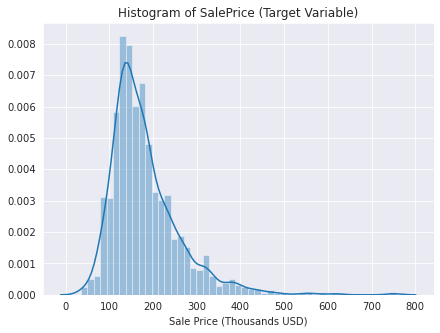

In [9]:
# Histogram of SalePrice (target variable)
y_thousands = y/1000
sns.distplot(y_thousands)
plt.title('Histogram of SalePrice (Target Variable)')
plt.xlabel('Sale Price (Thousands USD)');

We can create a correlation matrix to see how correlated the variables are with each other. We are interested in variables that are highly correlated with each other. For example, pairs of highly positively correlated variables (dark red squares) include GarageYrBlt and YearBuilt, GarageCars and GarageArea, 1stFlrSF and TotalBsmtSF; pairs of highly negatively correlated variables (dark blue squares) include BsmtFinSF1 and BsmtUnfSF, BsmtFullBath and BsmtUnfSF. 

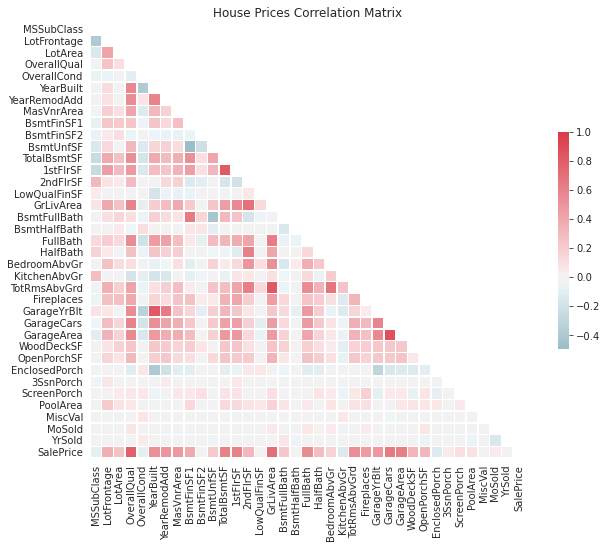

In [10]:
# Correlation matrix (based on https://seaborn.pydata.org/examples/many_pairwise_correlations.html)
plt.figure(figsize=(12, 8))
corr_matrix = house_data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

with sns.axes_style('white'):
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('House Prices Correlation Matrix');

The ten features most correlated with SalePrice (according to Pearson correlation) are listed below:

In [11]:
# Ten features most correlated with SalePrice (according to Pearson correlation)
top_ten_corr_features = corr_matrix.nlargest(n=11, columns='SalePrice')['SalePrice'][1:]
top_ten_corr_features

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

The scatterplots between SalePrice and each of the ten most correlated features show that variables such as OverallQual and GarageCars are actually categorical. We also see that for most of these variables, as their values increase, the variance of SalePrice increases as well. This phenomenon is called heteroscedasticity and can be alleviated by log transforming the variables.  

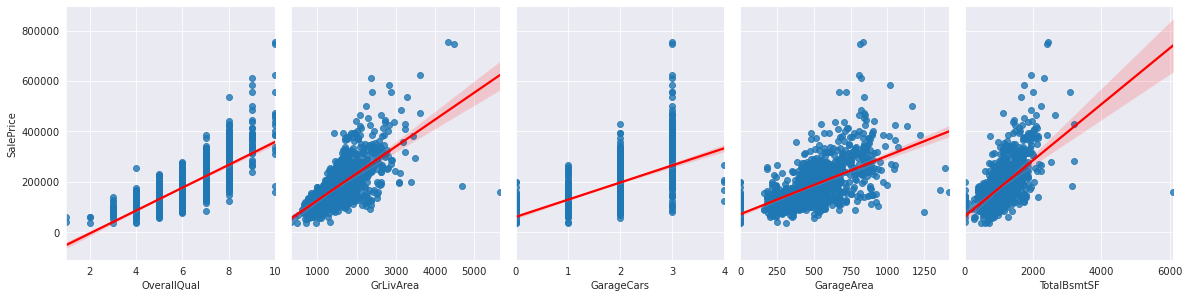

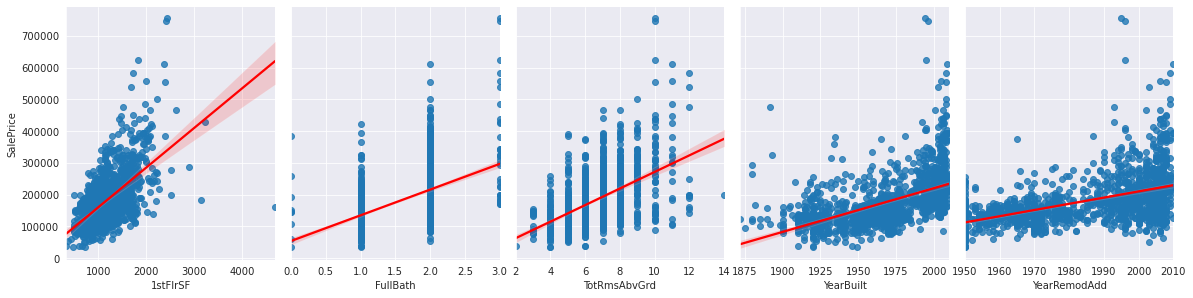

In [12]:
# Scatterplots of SalePrice vs. top ten correlated features (regression line in red)
sns.pairplot(data=house_data, y_vars=['SalePrice'], x_vars=top_ten_corr_features.index[:5], height=4, aspect=0.8, kind='reg', plot_kws={'line_kws':{'color':'red'}})
sns.pairplot(data=house_data, y_vars=['SalePrice'], x_vars=top_ten_corr_features.index[5:], height=4, aspect=0.8, kind='reg', plot_kws={'line_kws':{'color':'red'}});

Finally, since some of the variables are time-related, let's look at some time series plots.

If we plot the number of houses and the number of garages built for each year, we see that they are high correlated with each other. This is not surprising since we would expect the house and garage to be built at the same time.

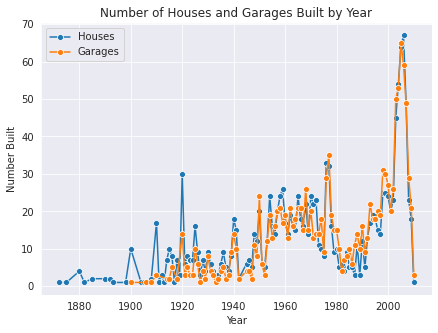

In [13]:
# Number of houses and garages built by year
sns.lineplot(data=house_data.YearBuilt.value_counts(), marker='o', label='Houses')
sns.lineplot(data=house_data.GarageYrBlt.value_counts(), marker='o', label='Garages')
plt.title('Number of Houses and Garages Built by Year')
plt.ylabel('Number Built')
plt.xlabel('Year')
plt.legend();

Interestingly, there is a seasonal effect to when houses are sold: the number of houses sold usually peaks around the middle of the year (June or July) and is lowest around the beginning of the year (January or February).

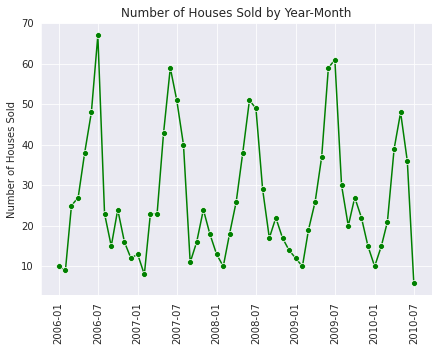

In [14]:
# Number of Houses Sold by Year-Month
YearMonthSold = pd.to_datetime(house_data.YrSold.apply(str) + '-' + house_data.MoSold.apply(str) + '-1')
sns.lineplot(data=YearMonthSold.value_counts(), marker='o', color='g')
plt.title('Number of Houses Sold by Year-Month')
plt.ylabel('Number of Houses Sold')
plt.xticks(rotation='vertical');

If we look at the trend of SalePrice over the years, we see that it strongly fluctuated before 2008 and is relatively more stable after 2008. We also see that prices generally rose during 2007, culminating in a sharp spike in December.

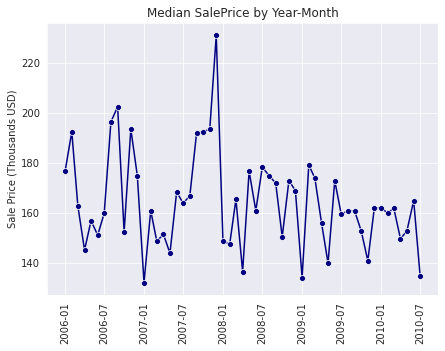

In [15]:
sns.lineplot(data=house_data.groupby(YearMonthSold)['SalePrice'].median()/1000, marker='o', color='navy')
plt.title('Median SalePrice by Year-Month')
plt.ylabel('Sale Price (Thousands USD)')
plt.xticks(rotation='vertical');

# 3. Preprocessing

## a. Missing Value Imputation

In [16]:
def impute(df, column, value):
    """
    Function that performs missing value imputation on a column or columns in a dataframe.
    
    Inputs:
    df (dataframe) -- dataframe of the column(s)
    column (string or list of strings) -- column name(s) of the column(s) to impute
    value (int, float, or string) -- value to impute
    """
    df[column] = df[column].fillna(value)

Let's take a look at which variables have missing values and the number of missing values in each variable for the training and test sets.

In [17]:
# Number of missing values in each column of the training set (excluding columns with no missing values)
X.isna().sum()[X.isna().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [18]:
# Number of missing values in each column of the test set (excluding columns with no missing values)
X_test.isna().sum()[X_test.isna().sum() > 0]

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

In [19]:
# Differences in variables with missing values between training and test sets
print('Variable with NA in training but not test set: ', set(X.columns[X.isna().any()].tolist()) - set(X_test.columns[X_test.isna().any()].tolist()))
print('Variables with NA in test but not training set: ', set(X_test.columns[X_test.isna().any()].tolist()) - set(X.columns[X.isna().any()].tolist()))

Variable with NA in training but not test set:  {'Electrical'}
Variables with NA in test but not training set:  {'BsmtUnfSF', 'Exterior1st', 'SaleType', 'Functional', 'GarageArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtFullBath', 'GarageCars', 'BsmtHalfBath', 'Exterior2nd', 'KitchenQual', 'Utilities', 'MSZoning'}


We see that there are more variables with missing values in the test set than the training set. To deal with missing values, we propose the following strategies based on the [data description](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). In particular, if the description for a categorical variable mentions a category for "NA", then we impute NA with "None"; otherwise, we impute NA with the most frequent value.  For numerical variables, we impute NA with 0 except for LotFrontage, which we impute with the median based on the neighborhood the house is located.

* `MSZoning`: Impute NA with the most frequent value.

In [20]:
impute(X, 'MSZoning', X['MSZoning'].value_counts().idxmax())
impute(X_test, 'MSZoning', X['MSZoning'].value_counts().idxmax())

* `LotFrontage`: Impute NA with the median 'LotFrontage' of the neighborhood the house is located. To avoid data leakage, we have to impute missing 'LotFrontage' in the test set with the median 'LotFrontage' (grouped by 'Neighborhood') from the training set. A way to do that is found [here](https://stackoverflow.com/questions/57699612/filling-in-missing-values-from-one-dataset-using-group-means-from-a-different-da).

In [21]:
X['LotFrontage'] = X['LotFrontage'].fillna(X.groupby('Neighborhood')['LotFrontage'].transform('median'))

# Create column for LotFrontage median grouped by Neighborhood
lotfrontage_median = pd.DataFrame(X.groupby('Neighborhood')['LotFrontage'].median()).rename(columns={'LotFrontage':'LotFrontage_median'})

# Merge LotFrontage median with test set
X_test_tmp = X_test.reset_index().merge(lotfrontage_median, on='Neighborhood').set_index('Id')

# Fill missing LotFrontage in test set with LotFrontage median
X_test_tmp['LotFrontage'] = X_test_tmp['LotFrontage'].fillna(X_test_tmp['LotFrontage_median'])

# Drop LotFrontage median
X_test = X_test_tmp.drop('LotFrontage_median', axis=1)

* `Alley`: Impute NA with "None".

In [22]:
impute(X, 'Alley', 'None')
impute(X_test, 'Alley', 'None')

* `Utilities`: Impute NA with the most frequent value.

In [23]:
impute(X, 'Utilities', X['Utilities'].value_counts().idxmax())
impute(X_test, 'Utilities', X['Utilities'].value_counts().idxmax())

* `Exterior1st` and `Exterior2nd`: Impute NA with the most frequent value.

In [24]:
impute(X, 'Exterior1st', X['Exterior1st'].value_counts().idxmax())
impute(X_test, 'Exterior1st', X['Exterior1st'].value_counts().idxmax())

impute(X, 'Exterior2nd', X['Exterior2nd'].value_counts().idxmax())
impute(X_test, 'Exterior2nd', X['Exterior2nd'].value_counts().idxmax())

* `MasVnrType`: Impute NA with "None".
* `MasVnrArea`: Impute NA with 0.

In [25]:
impute(X, 'MasVnrType', 'None')
impute(X_test, 'MasVnrType', 'None')

impute(X, 'MasVnrArea', 0)
impute(X_test, 'MasVnrArea', 0)

For basement-related variables, missing values indicate that the house has no basement.

`BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1`, `BsmtFinType2`, : Impute NA with "None".

`BsmtFinSF1`, `BsmtFinSF2`, `BsmtUnfSF`, `TotalBsmtSF`, `BsmtFullBath`, `BsmtHalfBath`: Impute NA with 0.

In [26]:
# Categorical basement-related columns
Bsmt_cat_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
# Numerical basement-realted columns
Bsmt_num_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']

impute(X, Bsmt_cat_cols, 'None')
impute(X_test, Bsmt_cat_cols, 'None')

impute(X, Bsmt_num_cols, 0)
impute(X_test, Bsmt_num_cols, 0)

* `KitchenQual`: Impute NA with the most frequent value.

In [27]:
impute(X, 'KitchenQual', X['KitchenQual'].value_counts().idxmax())
impute(X_test, 'KitchenQual', X['KitchenQual'].value_counts().idxmax())

* `Functional`: Impute NA with the most frequent value.

In [28]:
impute(X, 'Functional', X['Functional'].value_counts().idxmax())
impute(X_test, 'Functional', X['Functional'].value_counts().idxmax())

* `FireplaceQu`: Impute NA with "None".

In [29]:
impute(X, 'FireplaceQu', 'None')
impute(X_test, 'FireplaceQu', 'None')

For garage-related variables, missing values indicate that the house has no garage.

* `GarageType`, `GarageFinish`, `GarageQual`, `GarageCond`: Impute NA with "None".

* `GarageYrBlt`, `GarageCars`, `GarageArea`: Impute NA with 0.

In [30]:
# Categorical garage-related columns
Garage_cat_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
# Numerical garage-realted columns
Garage_num_cols = ['GarageYrBlt', 'GarageArea', 'GarageCars']

impute(X, Garage_cat_cols, 'None')
impute(X_test, Garage_cat_cols, 'None')

impute(X, Garage_num_cols, 0)
impute(X_test, Garage_num_cols, 0)

* `PoolQC`: Impute NA with "None".

In [31]:
impute(X, 'PoolQC', 'None')
impute(X_test, 'PoolQC', 'None')

* `Fence`: Impute NA with "None".

In [32]:
impute(X, 'Fence', 'None')
impute(X_test, 'Fence', 'None')

* `MiscFeature`: Impute NA with "None".

In [33]:
impute(X, 'MiscFeature', 'None')
impute(X_test, 'MiscFeature', 'None')

* `SaleType`: Impute NA with the most frequent value.

In [34]:
impute(X, 'SaleType', X['SaleType'].value_counts().idxmax())
impute(X_test, 'SaleType', X['SaleType'].value_counts().idxmax())

* `Electrical`: Impute NA with the most frequent value.

In [35]:
impute(X, 'Electrical', X['Electrical'].value_counts().idxmax())
impute(X_test, 'Electrical', X['Electrical'].value_counts().idxmax())

Finally, let's make sure that we imputed all missing values in the training and test sets.

In [36]:
# Make sure that there are no more NA
print('Number of NA in training set after imputation: ', X.isna().sum().sum())
print('Number of NA in test set after imputation: ', X_test.isna().sum().sum())

Number of NA in training set after imputation:  0
Number of NA in test set after imputation:  0


## b. Feature Engineering

Let's create some new features that can potentially improve predictive power (datatypes in parentheses):

* **TotalSF**: Total house square footage (int)
* **TotalPorchSF**: Total porch square footage (int)
* **TotalBath**: Total bathrooms (float)
* **TotalRooms**: Total rooms above grade including bathrooms (float)
* **HasGarage**: Does the house have a garage? (bool)
* **HasPool**: Does the house have a pool? (bool)
* **HasFireplace**: Does the house have a fireplace? (bool)
* **HasBasement**: Does the house have a basement? (bool)
* **Has2ndFloor**: Does the house have a 2nd floor? (bool)
* **IsRemodeled**: Has the house been remodeled? (bool)

In [37]:
def create_features(X):
    # Total house square footage
    X['TotalSF'] = X['TotalBsmtSF'] + X['GrLivArea']

    # Total porch square footage
    X['TotalPorchSF'] = X['OpenPorchSF'] + X['EnclosedPorch'] + X['3SsnPorch'] + X['ScreenPorch']

    # Total bathrooms
    X['TotalBath'] = X['BsmtFullBath'] + 0.5 * X['BsmtHalfBath'] + X['FullBath'] + 0.5 * X['HalfBath']

    # Total rooms above grade (including bathrooms)
    X['TotalRooms'] = X['TotRmsAbvGrd'] + X['FullBath'] + 0.5 * X['HalfBath']
    
    # Does the house have a garage?
    X['HasGarage'] = X['GarageArea'] > 0

    # Does the house have a pool?
    X['HasPool'] = X['PoolArea'] > 0

    # Does the house have a fireplace?
    X['HasFireplace'] = X['Fireplaces'] > 0

    # Does the house have a basement?
    X['HasBasement'] = X['TotalBsmtSF'] > 0

    # Does the house have a 2nd floor?
    X['Has2ndFloor'] = X['2ndFlrSF'] > 0
    
    # Has the house been remodeled?
    X['IsRemodeled'] = X['YearBuilt'] != X['YearRemodAdd']
    
    return X

X = create_features(X)
X_test = create_features(X_test)

~~To capture non-linear relationships, let's create polynomial features for the ten features most correlated with SalePrice.~~

In [38]:
# # Create a temporary dataframe with features and SalePrice
# df_temp = X.copy()
# df_temp['SalePrice'] = y

# # Check ten features most correlated with SalePrice
# corr_matrix = df_temp.corr()
# top_ten_corr_features = corr_matrix.nlargest(n=11, columns='SalePrice')['SalePrice'][1:]
# top_ten_corr_features

In [39]:
# # Create polynomial features for the ten features most correlated with SalePrice
# for col in top_ten_corr_features.index:
#     X[col + '^2'] = X[col] ** 2
#     X_test[col + '^2'] = X_test[col] ** 2
    
#     X[col + '^3'] = X[col] ** 3
#     X_test[col + '^3'] = X_test[col] ** 3
    
#     X[col + '^0.5'] = X[col] ** 0.5
#     X_test[col + '^0.5'] = X_test[col] ** 0.5

## c. Categorical Variable Encoding

In addition to missing value imputation, we need to convert all categorical variables to numeric since sklearn cannot handle categorical data. We will use ordinal encoding for categorical variables with intrinsic ordering and one-hot encoding for categorical variables without intrinsic ordering. Ordinal encoding assigns integers to categories based on order, and one-hot encoding creates a binary indicator variable for each category.

Before we encode the categorical variables, we should note that there are some numerical variables that should really be categorical (in particular, 'MSSubClass', 'MoSold', 'YrSold'), so these variables should first be converted to categorical then one-hot encoded.

In [40]:
# Convert these numerical variables to categorical
num_cols_to_cat = ['MSSubClass', 'MoSold', 'YrSold']
X[num_cols_to_cat] = X[num_cols_to_cat].astype(str)
X_test[num_cols_to_cat] = X_test[num_cols_to_cat].astype(str)

In [41]:
# Lists of categorical and numerical variables
cat_cols = [col for col in X.columns if X.dtypes[col] == 'object']
num_cols = [col for col in X.columns if X.dtypes[col] in ['int64', 'float64']]

In [42]:
# Ordinal encode the following categorical variables
def ordinal_encoder(X):
    X = X.replace({
        'Street': {'Pave':1, 'Grvl':2},
        'Alley': {'None':0, 'Pave':1, 'Grvl':2},
        'LotShape': {'IR3':1, 'IR2':2, 'IR1':3, 'Reg':4},
        'Utilities': {'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4},
        'LandSlope': {'Sev':1, 'Mod':2, 'Gtl':3},
        'ExterQual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
        'ExterCond': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
        'BsmtQual': {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
        'BsmtCond': {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
        'BsmtExposure': {'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4},
        'BsmtFinType1': {'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
        'BsmtFinType2': {'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
        'HeatingQC': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
        'KitchenQual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
        'Functional': {'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8},
        'FireplaceQu': {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
        'GarageFinish': {'None':0, 'Unf':1, 'RFn':2, 'Fin':3},
        'GarageQual': {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
        'GarageCond': {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
        'PavedDrive': {'N':0, 'P':1, 'Y':2},
        'PoolQC': {'None':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4},
        'Fence': {'None':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4},
        'Electrical':{'Mix':1, 'FuseP':2, 'FuseF':3, 'FuseA':4, 'SBrkr':5}
    })
    return X

X = ordinal_encoder(X)
X_test = ordinal_encoder(X_test)

In [43]:
# Apply one-hot encoding to training and test sets
X = pd.get_dummies(X)
X_test = pd.get_dummies(X_test)

After missing value imputation and categorical variable encoding, we find that the training set now has more columns than the test set. This is due to certain values of categorical variables that are found only in the training set; these values are used to create dummy variables, which are found only in the training set as well.

In [44]:
# Training set now has more columns test set due to dummy variables only found in training set
print(X.shape)
print(X_test.shape)

(1460, 257)
(1459, 244)


We can deal with this disparity by adding these extra dummy variables to the test set as columns of 0's. The resulting test set should have the same number of columns as the training set.

In [45]:
# Find columns that are in training set but not test set
missing_cols = set(X.columns) - set(X_test.columns)

# Add these columns to test set filled with 0's
for col in missing_cols:
    X_test[col] = 0
    
# Align columns of training and test sets
X_test = X_test[X.columns]

print(X.shape)
print(X_test.shape)

(1460, 257)
(1459, 257)


## d. Log Transformations, Feature Selection, and Scaling

Recall that the target variable, SalePrice, is right-skewed, so we should log transform it to make it more normally distributed.

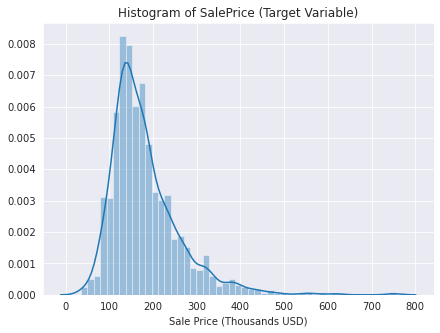

In [46]:
# Histogram of SalePrice (target variable)
y_thousands = y/1000
sns.distplot(y_thousands)
plt.title('Histogram of SalePrice (Target Variable)')
plt.xlabel('Sale Price (Thousands USD)');

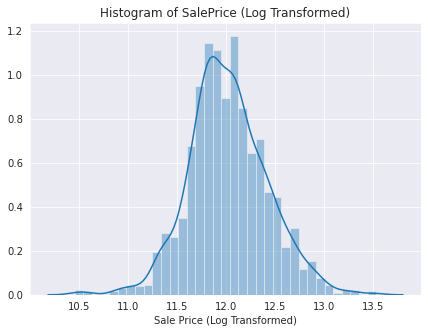

In [47]:
# Log transform SalePrice: log(1 + SalePrice)
y = np.log1p(y)

# Histogram of SalePrice (log transformed)
sns.distplot(y)
plt.title('Histogram of SalePrice (Log Transformed)')
plt.xlabel('Sale Price (Log Transformed)');

We should also log transform the numerical variables (excluding encoded variables) with skewness less than -0.5 (left-skewed) or greater than 0.5 (right-skewed).

In [48]:
# Calculate skewness for numerical variables
skewness = X[num_cols].apply(lambda x: skew(x))
skewed_cols = skewness[abs(skewness) > 0.5].index

# Log transform skewed numerical variables 
X[skewed_cols] = np.log1p(X[skewed_cols])
X_test[skewed_cols] = np.log1p(X_test[skewed_cols])

We will also perform some initial feature selection. Concretely, a feature with very low variance (i.e. a feature with mostly the same values) generally has low predictive power. To be on the conservative side, we will remove all features with less than 0.01 or 1% variance. This leaves us with 188 features out of 257 from before.

In [49]:
# Set variance threshold to 0.01
sel = VarianceThreshold(threshold=0.01)
sel.fit(X)
print('Number of features remaining:', sel.get_support().sum())

Number of features remaining: 188


In [50]:
# Remove any feature with variance less than 0.01
X = X[[col for col in X.columns[sel.get_support()]]]
X_test = X_test[[col for col in X_test.columns[sel.get_support()]]]

As the final step of preprocessing, we scale the features with [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html).

In [51]:
# Feature scaling
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Scaling removes column names and index; get them back
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# 4. Modeling

Now that we are finally finished with preprocessing the data, we can move onto modeling. In particular, we are interested in linear regression with and without regularization as well as XGBoost, which is an algorithm that is very popular here on Kaggle. We need to apply regularization to linear regression to prevent overfitting since after preprocessing, we ended up with 188 features, many of which are correlated (multicollinearity). Regularization imposes a penalty term on the OLS cost function. We will look at three types of regularization: ridge, lasso, and elastic net.

**Ridge** regression penalizes the sum of squared coefficients (L2 penalty). It shrinks the size of coefficients but not to exactly zero. **Lasso** regression, on the other hand, penalizes the sum of the absolute values of the coefficients (L1 penalty), which can shrink coefficients to exactly zero. Thus, lasso performs variable selection, while ridge does not. **Elastic net** regression serves as a compromise between lasso and ridge and uses a penalty that is a combination of L1 and L2.

In [52]:
# Fuction to calculate RMSE
def CV_rmse(estimator, X, y, cv):
    rmse = -cross_val_score(estimator=estimator, X=X, y=y, cv=cv, scoring='neg_root_mean_squared_error')
    return rmse

## a. Linear Regression (No Regularization)

In [53]:
linear_model = LinearRegression()

rmse = CV_rmse(estimator=linear_model, X=X_scaled, y=y, cv=10)
print('Linear Regression RMSE:', rmse.mean())

Linear Regression RMSE: 0.12963975132563207


## b. Ridge Regression

In [54]:
# # Tuning
# params = {'alpha': range(1, 50, 2)}

# ridge_cv = GridSearchCV(estimator=Ridge(max_iter=20000, random_state=1), param_grid=params, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
# ridge_cv.fit(X_scaled, y)
# print('Ridge Regression Best Alpha:', ridge_cv.best_params_['alpha'])
# print('Ridge Regression RMSE:', -ridge_cv.best_score_)

In [55]:
ridge_cv = Ridge(alpha=25, max_iter=20000, random_state=1)
ridge_cv.fit(X_scaled, y)

rmse = CV_rmse(estimator=ridge_cv, X=X_scaled, y=y, cv=10)
print('Ridge Regression RMSE:', rmse.mean())

Ridge Regression RMSE: 0.12476679826213792


In [56]:
# Ridge test predictions 
ridge_pred = np.expm1(ridge_cv.predict(X_test_scaled))

## c. Lasso Regression

In [57]:
# # Tuning
# params = {'alpha': [0.0005, 0.0006, 0.0007, 0.0008, 0.0009]}

# lasso_cv = GridSearchCV(estimator=Lasso(max_iter=20000, random_state=1), param_grid=params, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
# lasso_cv.fit(X_scaled, y)
# print('Lasso Regression Best Alpha:', lasso_cv.best_params_['alpha'])
# print('Lasso Regression RMSE:', -lasso_cv.best_score_)

In [58]:
lasso_cv = Lasso(alpha=0.0008, max_iter=20000, random_state=1)
lasso_cv.fit(X_scaled, y)

rmse = CV_rmse(estimator=lasso_cv, X=X_scaled, y=y, cv=10)
print('Lasso Regression RMSE:', rmse.mean())

Lasso Regression RMSE: 0.12348544625397725


In [59]:
# Lasso test predictions 
lasso_pred = np.expm1(lasso_cv.predict(X_test_scaled))

## d. Elastic Net Regression

In this case, elastic net regression ended up being identical to lasso regression (L2 regularization was not used).

In [60]:
# # Tuning
# params = {'alpha': [0.0005, 0.0006, 0.0007, 0.0008, 0.0009],
#          'l1_ratio': np.linspace(0.7, 1, 10)}

# elasticnet_cv = GridSearchCV(estimator=ElasticNet(max_iter=20000, random_state=1), param_grid=params, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
# elasticnet_cv.fit(X_scaled, y)
# print('ElasticNet Regression Best Alpha:', elasticnet_cv.best_params_['alpha'])
# print('ElasticNet Regression Best L1 Ratio:', elasticnet_cv.best_params_['l1_ratio'])
# print('ElasticNet Regression RMSE:', -elasticnet_cv.best_score_)

In [61]:
elasticnet_cv = ElasticNet(alpha=0.0008, l1_ratio=1.0, max_iter=20000, random_state=1)
elasticnet_cv.fit(X_scaled, y)

rmse = CV_rmse(estimator=elasticnet_cv, X=X_scaled, y=y, cv=10)
print('ElasticNet Regression RMSE:', rmse.mean())

ElasticNet Regression RMSE: 0.12348544625397725


In [62]:
# ElasticNet test predictions 
elasticnet_pred = np.expm1(elasticnet_cv.predict(X_test_scaled))

## e. XGBoost

Now let's see how XGBoost with default parameters performs.

In [63]:
xgb_model = xgb.XGBRegressor(random_state=1)

rmse = CV_rmse(estimator=xgb_model, X=X, y=y, cv=10)
print('XGBoost (untuned) RMSE:', rmse.mean())

XGBoost (untuned) RMSE: 0.13739814451521354


We can tune the parameters for even better performance (for brevity, I excluded the code for hyperparameter tuning). Click [here](https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f) for a Cambridge Spark tutorial on hyperparameter tuning in XGBoost.

In [64]:
# XGBoost with tuned parameters
xbg_model_tuned = xgb.XGBRegressor(max_depth=3, min_child_weight=6, learning_rate=0.03, subsample=0.7, colsample_bytree=0.8, n_estimators=727, random_state=1)

xbg_model_tuned.fit(X, y)
rmse = CV_rmse(estimator=xbg_model_tuned, X=X, y=y, cv=10)
print('XGBoost (tuned) RMSE:', rmse.mean())

XGBoost (tuned) RMSE: 0.12252109466133365


In [65]:
# XGBoost test predictions 
xgb_pred = np.expm1(xbg_model_tuned.predict(X_test))

# 5. Averaging Test Predictions

Let's average the predictions generated by ridge, lasso, and XGBoost; we won't include elastic net since in this case, it is identical to lasso. The weights I assigned to the three models are pretty arbitrary; I decided to weigh ridge less than lasso and XGBoost since it resulted in the highest CV error. I am probably going to do more research into determining the optimal weights and also whether ridge should be included in the first place.

In [66]:
avg_pred = 0.2 * ridge_pred + 0.4 * lasso_pred + 0.4 * xgb_pred

In [67]:
#avg_pred = np.array([ridge_pred, lasso_pred, xgb_pred]).mean(axis=0)

In [68]:
# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                        'SalePrice': avg_pred})
output.to_csv('submission.csv', index=False)

In [69]:
# from IPython.display import FileLink
# FileLink('submission.csv')

# 6. Conclusion

From our analysis on the Ames housing data, we saw just how powerful linear regression with regularization can be with thorough preprocessing. This demonstrates that it isn't always about using the best state of the art algorithms but rather understanding and manipulating the data to extract the maximum insights. To improve on our results even further, we can try more models, stacking, and possibly even more feature engineering.

Thank you for reading!